# Analyze splicing ReLiC screen

## Define libraries and analysis-specific parameters

In [1]:
options(warn = -1, repr.matrix.max.rows = 10)

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))

cbPalette_12 <- c(
  "#88CCEE", "#CC6677", "#117733", "#999933", "#332288", "#AA4499",
  "#661100", "#44AA99", "#882255", "#6699CC", "#DDCC77", "#888888"
)

theme_set(theme_rasilab() + 
 theme(
  axis.line = element_line(color = "grey"), 
 axis.title.y = element_text(margin = margin(r=10)),
 axis.title.x = element_text(margin = margin(t=10))
))

fdr_cutoff <- 0.05
sgrna_cutoff <- 3

## Load MaGeCK gene hit data

In [2]:
mageck_gene <- list.files("../data/mageck/", full.names = T, recursive = T, pattern = "gene_summary.tsv$") %>%
  as_tibble_col("file") %>%
  filter(str_detect(file, "ntc"), str_detect(file, "retained|skipped")) %>%
  mutate(sample_name = str_extract(file, "(?<=mageck//).+(?=/mageck.)")) %>%
  separate(sample_name, c("treatment", "control"), sep = "_vs_", remove = F) %>%
  mutate(data = map(file, . %>% read_tsv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  janitor::clean_names() %>%
  select(-neg_lfc) %>%
  rename(lfc = pos_lfc, gene = id) %>%
  filter(!str_detect(gene, "MCHERRY|PURO")) %>%
  mutate(pos_fdr = if_else(is.na(pos_fdr), 1, pos_fdr)) %>%
  arrange(pos_rank) 

mageck_gene

sample_name,treatment,control,gene,num,neg_score,neg_p_value,neg_fdr,neg_rank,neg_goodsgrna,pos_score,pos_p_value,pos_fdr,pos_rank,pos_goodsgrna,lfc
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ntc_day1_bc1_e2_skipped_vs_ntc_day1_bc1_total,ntc_day1_bc1_e2_skipped,ntc_day1_bc1_total,UBE2O,4,0.99994,0.99995,NA,2186,0,6.0735e-05,0.00021061,0.073503,1,4,5.26450
ntc_day1_bc1_i1_retained_vs_ntc_day1_bc1_total,ntc_day1_bc1_i1_retained,ntc_day1_bc1_total,MKRN1,3,0.79523,0.79613,NA,1769,0,2.5948e-05,0.00009285,1.000000,1,2,1.64320
ntc_day1_bc1_i2_retained_vs_ntc_day1_bc1_total,ntc_day1_bc1_i2_retained,ntc_day1_bc1_total,RPUSD4,4,0.99994,0.99995,NA,2186,0,5.6225e-05,0.00019249,0.032539,1,4,0.40788
ntc_day3_bc1_e2_skipped_vs_ntc_day3_bc1_total,ntc_day3_bc1_e2_skipped,ntc_day3_bc1_total,SF3B1,4,0.99988,0.99988,NA,2186,0,1.2384e-04,0.00046425,0.151810,1,4,2.34100
ntc_day3_bc1_i1_retained_vs_ntc_day3_bc1_total,ntc_day3_bc1_i1_retained,ntc_day3_bc1_total,PLRG1,4,0.99940,0.99943,NA,2184,0,3.0387e-05,0.00011097,0.045497,1,4,1.15190
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ntc_day5_bc1_i1_retained_vs_ntc_day5_bc1_total,ntc_day5_bc1_i1_retained,ntc_day5_bc1_total,U2AF2,4,8.1614e-05,2.9214e-04,0.100788,1,4,0.99992,0.99993,1.000000,2186,0,-3.51890
ntc_day5_bc1_i2_retained_vs_ntc_day5_bc1_total,ntc_day5_bc1_i2_retained,ntc_day5_bc1_total,TUBGCP3,4,2.8468e-05,1.0191e-04,0.016815,2,4,0.99997,0.99997,1.000000,2186,0,-0.46165
ntc_day7_dmso_bc1_e2_skipped_vs_ntc_day7_dmso_bc1_total,ntc_day7_dmso_bc1_e2_skipped,ntc_day7_dmso_bc1_total,H1-10,4,3.8016e-04,1.5377e-03,0.111012,4,4,0.99962,0.99962,1.000000,2186,0,-1.14920


## Load MaGeCK sgrna hit data

In [3]:
mageck_sgrna <- list.files("../data/mageck/", full.names = T, recursive = T, pattern = "sgrna_summary.tsv$") %>%
  as_tibble_col("file") %>%
  filter(str_detect(file, "ntc"), str_detect(file, "retained|skipped")) %>%
  mutate(sample_name = str_extract(file, "(?<=mageck//).+(?=/mageck.)")) %>%
  separate(sample_name, c("treatment", "control"), sep = "_vs_", remove = F) %>%
  mutate(data = map(file, . %>% read_tsv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  janitor::clean_names()

mageck_sgrna

sample_name,treatment,control,sgrna,gene,control_count,treatment_count,control_mean,treat_mean,lfc,control_var,adj_var,score,p_low,p_high,p_twosided,fdr,high_in_treatment
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
ntc_day1_bc1_e2_skipped_vs_ntc_day1_bc1_total,ntc_day1_bc1_e2_skipped,ntc_day1_bc1_total,PINX1_2_3,PINX1,20.372,13884,20.372,13884,9.3436,96096000,1710.8,335.17,1,0,0,0,TRUE
ntc_day1_bc1_e2_skipped_vs_ntc_day1_bc1_total,ntc_day1_bc1_e2_skipped,ntc_day1_bc1_total,YBX1_4_1,YBX1,16.599,10673,16.599,10673,9.2445,56784000,1036.8,330.97,1,0,0,0,TRUE
ntc_day1_bc1_e2_skipped_vs_ntc_day1_bc1_total,ntc_day1_bc1_e2_skipped,ntc_day1_bc1_total,EIF4G3_4_1,EIF4G3,69.414,56196,69.414,56196,9.6404,1575100000,34817.0,300.79,1,0,0,0,TRUE
ntc_day1_bc1_e2_skipped_vs_ntc_day1_bc1_total,ntc_day1_bc1_e2_skipped,ntc_day1_bc1_total,TRIM25_3_4,TRIM25,93.558,68951,93.558,68951,9.5102,2370600000,72637.0,255.49,1,0,0,0,TRUE
ntc_day1_bc1_e2_skipped_vs_ntc_day1_bc1_total,ntc_day1_bc1_e2_skipped,ntc_day1_bc1_total,EIF4E3_2_3,EIF4E3,53.318,33158,53.318,33158,9.2537,547940000,18183.0,245.50,1,0,0,0,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ntc_day7_dmso_bc1_i2_retained_vs_ntc_day7_dmso_bc1_total,ntc_day7_dmso_bc1_i2_retained,ntc_day7_dmso_bc1_total,ZC3H15_4_1,ZC3H15,3369.30,3369.90,3369.30,3369.90,2.5028e-04,0.17096000,51064.0,0.00258760,0.50103,0.49897,0.99794,0.99852,TRUE
ntc_day7_dmso_bc1_i2_retained_vs_ntc_day7_dmso_bc1_total,ntc_day7_dmso_bc1_i2_retained,ntc_day7_dmso_bc1_total,EXOSC9_4_1,EXOSC9,1290.30,1290.60,1290.30,1290.60,2.5846e-04,0.02676600,17437.0,0.00175210,0.50070,0.49930,0.99860,0.99906,TRUE
ntc_day7_dmso_bc1_i2_retained_vs_ntc_day7_dmso_bc1_total,ntc_day7_dmso_bc1_i2_retained,ntc_day7_dmso_bc1_total,ZC3HAV1_2_3,ZC3HAV1,3752.20,3752.60,3752.20,3752.60,1.4934e-04,0.07547600,57606.0,0.00161880,0.50065,0.49935,0.99871,0.99906,TRUE


## Plot number of hits on different days

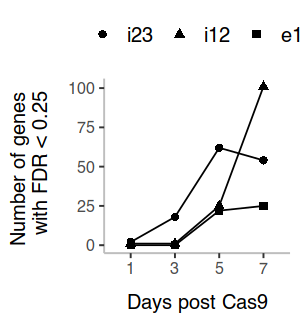

In [4]:
options(repr.plot.width = 2.5, repr.plot.height = 2.7)
plot_data <- mageck_gene  %>% 
  group_by(treatment, control) %>%
  summarize(n_fdr = sum(pos_fdr < fdr_cutoff), .groups = "drop") %>% 
  filter(str_detect(treatment, "day")) %>%
  mutate(day = str_extract(treatment, "(?<=day)\\d+")) %>%
  mutate(isoform = str_extract(treatment, "e2|i1|i2(?=.+)")) %>% 
  mutate(isoform = case_when(
    isoform == "e2" ~ "e13",
    isoform == "i1" ~ "i12",
    isoform == "i2" ~ "i23",
    TRUE ~ "other"
  )) %>% 
  mutate(isoform = fct_relevel(isoform, "i23", "i12", "e13", "other"))

plot_data %>% 
  ggplot(aes(x = day, y = n_fdr, fill = isoform, group = isoform, shape = isoform)) +
  geom_point(size = 2) +
  geom_line() +
  labs(x = "Days post Cas9", y = "Number of genes \n with FDR < 0.25") +
  theme(legend.position = "top", legend.direction = "horizontal", legend.title = element_blank())

ggsave("../figures/splicing_n_hits.pdf", width = 2.5, height = 2.7, units = "in")

## Show the number of hits as a table

In [5]:
options(repr.matrix.max.rows = 12)
plot_data

treatment,control,n_fdr,day,isoform
<chr>,<chr>,<int>,<chr>,<fct>
ntc_day1_bc1_e2_skipped,ntc_day1_bc1_total,0,1,e13
ntc_day1_bc1_i1_retained,ntc_day1_bc1_total,1,1,i12
ntc_day1_bc1_i2_retained,ntc_day1_bc1_total,2,1,i23
ntc_day3_bc1_e2_skipped,ntc_day3_bc1_total,0,3,e13
ntc_day3_bc1_i1_retained,ntc_day3_bc1_total,1,3,i12
ntc_day3_bc1_i2_retained,ntc_day3_bc1_total,18,3,i23
ntc_day5_bc1_e2_skipped,ntc_day5_bc1_total,22,5,e13
ntc_day5_bc1_i1_retained,ntc_day5_bc1_total,25,5,i12
ntc_day5_bc1_i2_retained,ntc_day5_bc1_total,62,5,i23


## Load Splicing hit annotations

In [6]:
splicing_hit_annotations <- read_csv("../annotations/splicing_hit_annotations.csv", show_col_types = FALSE) %>%
  print()

# A tibble: 100 × 3
   gene   annotation                      comment      
   <chr>  <chr>                           <chr>        
 1 AQR    Spliceosome/splicing-associated IBC, helicase
 2 BRF2   Spliceosome/splicing-associated NA           
 3 BUD13  Spliceosome/splicing-associated RES          
 4 CACTIN Spliceosome/splicing-associated C            
 5 CDC40  Spliceosome/splicing-associated Step 2       
 6 CDC5L  Spliceosome/splicing-associated NTC          
 7 CDK11B Spliceosome/splicing-associated NA           
 8 CRNKL1 Spliceosome/splicing-associated NTC          
 9 RBM22  Spliceosome/splicing-associated NTC          
10 ZMAT2  Spliceosome/splicing-associated B            
# … with 90 more rows


## Volcano plot of P value vs fold change  for different isoforms

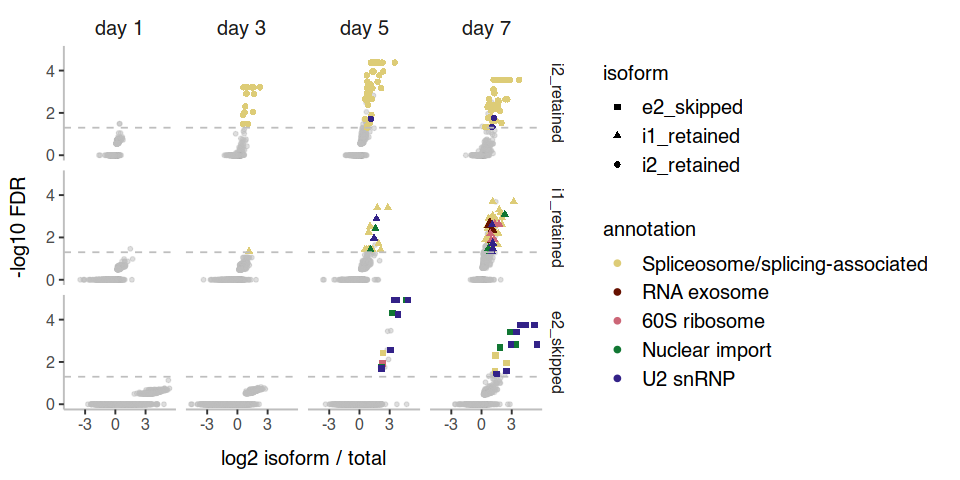

In [7]:
options(repr.plot.width = 8, repr.plot.height = 4)

plot_data <- mageck_gene %>%
  filter(str_detect(treatment, "day")) %>%
  mutate(day = str_replace(str_extract(treatment, "day\\d+"), "day", "day ")) %>%
  mutate(isoform = str_extract(treatment, "(e2|i1|i2)_.+")) %>%
  group_by(isoform) %>% 
  mutate(fdr_cutoff = fdr_cutoff) %>%
  ungroup() %>% 
  left_join(splicing_hit_annotations, by = "gene") %>%
  mutate(annotation = fct_relevel(annotation, "Spliceosome/splicing-associated", "SF3a/b", "Translation", "RNA exosome")) %>%
  arrange(annotation)

plot_data %>%
  ggplot(aes(x = lfc, y = -log10(pos_fdr), color = annotation, shape = isoform)) +
  facet_grid(fct_rev(isoform) ~ day) +
  geom_point(size = 1, alpha = 0.5, data = plot_data %>% filter(is.na(annotation) | pos_fdr > fdr_cutoff), color = "grey", shape = "circle") +
  geom_point(alpha = 1, data = plot_data %>% filter(!is.na(annotation), pos_fdr < fdr_cutoff)) +
  geom_hline(yintercept = -log10(fdr_cutoff), linetype = 2, linewidth = 0.5, color = "grey") +
  scale_x_continuous(breaks= c(-3, 0, 3)) +
  scale_y_continuous(breaks = c(0, 2, 4)) +
  scale_color_manual(values = cbPalette_12[c(11,7,2,3,5)]) +
  scale_shape_manual(values = c(15,17,16,18,3)) +
  labs(x = "log2 isoform / total", y = "-log10 FDR")

ggsave("../figures/splicing_volcano.pdf", width = 8, height = 4, units = "in")

## LFC for SF3b complex

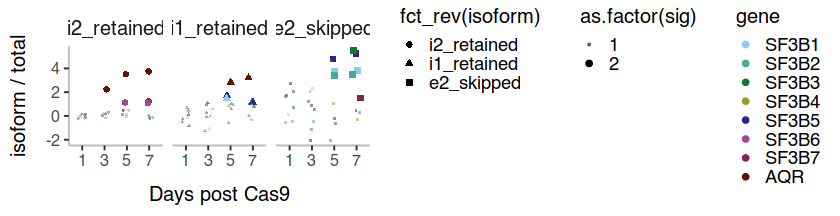

In [8]:
options(repr.plot.width = 7, repr.plot.height = 1.8)

plot_data <- mageck_gene %>%
  filter(str_detect(treatment, "day")) %>%
  mutate(day = str_extract(treatment, "(?<=day)\\d+")) %>%
  mutate(isoform = str_extract(treatment, "(e2|i1|i2)_.+")) %>% 
  mutate(gene = if_else(gene == "PHF5A", "SF3B7", gene)) %>% 
  filter(str_detect(gene, "^SF3B|AQR")) %>% 
  mutate(sig = case_when(
                pos_fdr >= 0.05 ~ 1,
                pos_fdr < 0.05 ~ 2,
                )) %>% 
  mutate(gene = fct_relevel(gene, "SF3B1", "SF3B2", "SF3B3", "SF3B4", "SF3B5", "SF3B6", "SF3B7", "AQR", "XAB2", "ISY1", "PPIE"))

plot_data %>%
  ggplot(aes(x = day, y = lfc, color = gene, group = gene, size = as.factor(sig), alpha = as.factor(sig), shape = fct_rev(isoform))) +
  facet_wrap(~fct_rev(isoform), ncol = 3, scales = "fixed") +
  # geom_line(size = 1) +
  geom_point(position = position_jitter(width = 0.2, height = 0, seed = 111)) +
  scale_color_manual(values = cbPalette_12[c(1,8,3,4,5,6,9,7,2,10,11)]) +
  scale_size_manual(values = c(0.5, 1.5)) +
  scale_alpha_manual(values = c(0.5, 1)) +
  labs(x = "Days post Cas9", y = "isoform / total") +
  theme(legend.box = "horizontal", legend.key.size = unit(0.4, "cm"), legend.text = element_text(size = 11))

ggsave("../figures/sf3b_lfc.pdf", width = 7, height = 1.8, units = "in")

## Load gene ontology analysis from GORILLA

In [9]:
subset_go_terms <- c(
  "GO:0005681" = 1,
  "GO:0046540" = 1.5,
  "GO:0005686" = 2,
  "GO:0022625" = 3,
  "GO:0006413" = 4,
  "GO:0051170" = 5,
  # "GO:0000502" = "proteasome complex",
  # "GO:0005832" = "chaperonin-containing T-complex"
  NULL
)

In [10]:
gorilla <- list.files("../data/gorilla/", full.names = T, pattern = "retained|skipped") %>% 
  read_csv(show_col_types = F, id = "filename") %>% 
  janitor::clean_names() %>% 
  mutate(isoform= str_extract(filename, "i2|i1|e2")) %>% 
  mutate(enrichment = as.numeric(str_extract(enrichment_n_b_n_b, "\\d+\\.\\d+"))) %>%
  select(isoform, go_term, description, fdr_q_value, enrichment, ontology) %>% 
  filter(go_term %in% names(subset_go_terms)) %>%
  print()

# A tibble: 12 × 6
   isoform go_term    description                       fdr_q_…¹ enric…² ontol…³
   <chr>   <chr>      <chr>                                <dbl>   <dbl> <chr>  
 1 e2      GO:0051170 import into nucleus               1.23e- 2   20.7  Process
 2 e2      GO:0005686 U2 snRNP                          5.51e-10   51.8  Compon…
 3 e2      GO:0005681 spliceosomal complex              9.44e- 7    8.74 Compon…
 4 e2      GO:0046540 U4/U6 x U5 tri-snRNP complex      1.91e- 5    4.75 Compon…
 5 i1      GO:0006413 translational initiation          6.05e- 6    1.55 Process
 6 i1      GO:0051170 import into nucleus               9.69e- 3    3.32 Process
 7 i1      GO:0005681 spliceosomal complex              2.62e-21    4.32 Compon…
 8 i1      GO:0046540 U4/U6 x U5 tri-snRNP complex      9.65e- 6    4.81 Compon…
 9 i1      GO:0005686 U2 snRNP                          1.71e- 5    7.17 Compon…
10 i1      GO:0022625 cytosolic large ribosomal subunit 1.48e- 4    3.67 Compon…
11 i2    

## Plot enrichment of GO terms

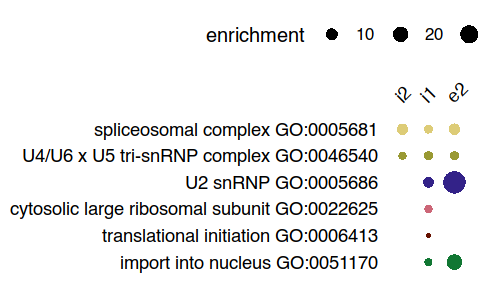

In [11]:
options(repr.plot.width = 4, repr.plot.height = 2.4)
plot_data <- gorilla %>%
  complete(isoform, nesting(go_term, description), fill = list(fdr_q_value = NA, enrichment = NA)) %>% 
  # mutate(ns = if_else(fdr_q_value >= 5e-2, "–", as.character(NA))) %>%
  # mutate(enrichment = if_else(enrichment > 10, 10, enrichment)) %>%
  # mutate(enrichment = if_else(classic_fisher >= 5e-2, as.numeric(NA), enrichment)) %>%
  mutate(y = str_c(description, " ", go_term)) %>% 
  mutate(y = fct_reorder(y, -subset_go_terms[go_term])) 


plot_data %>%
  ggplot(aes(x = fct_rev(isoform), y = y, size = enrichment, color = y)) +
  geom_point(shape = 16) +
  # geom_text(aes(label = )) +
  scale_color_manual(values = cbPalette_12[c(3,7,2,5,4,11)]) +
  theme(axis.text.x = element_text(angle = 45, hjust = 0),
  panel.grid.minor = element_line(size = 1, color = "grey"),
  legend.text = element_text(size = 10),
  axis.line = element_blank(),
  axis.ticks = element_blank(),
  legend.position = "top",
  axis.text = element_text(size = 11, color = "black"),
  axis.title.x = element_blank(), axis.title.y = element_blank()) +
  guides(color = F) +
  scale_x_discrete(position = "top")

ggsave("../figures/splicing_go_enrichment.pdf", width = 4, height = 2.4, units = "in")